In [1]:
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import random
import pandas as pd

In [2]:
mat = np.load('mat1.npy')

mat = mat[:,:,:720] + 1

flat_mat = mat[0]
for d in range(1, 31):
    flat_mat = np.hstack([flat_mat, mat[d]])
    
mat = None

K = 64


eye = np.eye(K)

In [3]:
def eva_for_mat(true_mat, pre_mat):
    eva = 0
    index = np.argwhere(true_mat > 0)
    for i,j in index:
        eva += (true_mat[i,j] - pre_mat[i, j]) ** 2
    eva = eva / len(index)
    return eva

In [4]:
P = np.random.normal(loc=0.1, scale=0.01, size=(flat_mat.shape[0], K))
Q = np.random.normal(loc=0.1, scale=0.01, size=(flat_mat.shape[1], K))


p_related_list = []
for i in range(len(P)):
    p_related_list.append(np.argwhere(flat_mat[i,:] > 0).flatten())
q_related_list = []
for j in range(len(Q)):
    q_related_list.append(np.argwhere(flat_mat[:,j] > 0).flatten())

In [5]:
for step in range(5):
    for i in tqdm(range(len(P))):
        p_related = p_related_list[i]
        if len(p_related) > K:
            P[i] = np.dot(np.dot(flat_mat[i, p_related], Q[p_related]),
                          np.linalg.pinv(np.dot(Q[p_related].T, Q[p_related])))
        else:
            P[i] = np.dot(np.dot(flat_mat[i, p_related], Q[p_related]),
                          np.linalg.pinv(np.dot(Q[p_related].T, Q[p_related]) + eye))
        if np.average(P[i]) > 10 or np.average(P[i]) < -10:
            raise
    np.save('P.npy',P)
    print(np.average((flat_mat[flat_mat > 0] - np.dot(P,Q.T)[flat_mat > 0])**2))
        
    for j in tqdm(range(len(Q))):
        q_related = q_related_list[j]
        if len(q_related) > K:
            Q[j] = np.dot(np.dot(flat_mat[q_related,j].T, P[q_related]),
                      np.linalg.pinv(np.dot(P[q_related].T, P[q_related])))
        else:
            Q[j] = np.dot(np.dot(flat_mat[q_related,j].T, P[q_related]),
                      np.linalg.pinv(np.dot(P[q_related].T, P[q_related]) + eye))
        if np.average(Q[j]) > 10 or np.average(Q[j]) < -10:
            raise
    np.save('Q.npy',Q)
    print(np.average((flat_mat[flat_mat > 0] - np.dot(P,Q.T)[flat_mat > 0])**2))

  0%|          | 14/22320 [00:00<02:40, 139.31it/s]

0.2963146868742293


  0%|          | 9/15584 [00:00<03:01, 85.81it/s]

0.23270076286161223


  0%|          | 13/22320 [00:00<02:59, 123.93it/s]

0.1952798318064822


  0%|          | 8/15584 [00:00<03:20, 77.61it/s]

0.18352719825889868


  0%|          | 13/22320 [00:00<03:01, 122.63it/s]

0.17863821773275154


  0%|          | 7/15584 [00:00<04:15, 60.85it/s]

0.17598882124142343


  0%|          | 13/22320 [00:00<03:05, 120.49it/s]

0.17442193766684078


  0%|          | 9/15584 [00:00<02:57, 87.74it/s]

0.1733782220122317


  0%|          | 13/22320 [00:00<03:02, 122.49it/s]

0.1726623170549703


100%|██████████| 22320/22320 [03:03<00:00, 121.94it/s]


0.1721316438203487


In [101]:
### 构造翌日隐含因子
week_features = []
for week in range(7):
    temp = []
    for i in [week + i * 7 for i in range(4)]:
        temp.append(Q[i * 720: (i+1) * 720])
    temp = np.array(temp)
    week_features.append(np.average(temp, axis = 0))

In [109]:
### 构造周趋势
week_lambda = []
for i in range(5):
    index = [x+i*7 for x in [0,1,2]]
    week_lambda.append(np.sum(mat[index]) / np.sum(mat[index] > 0))

In [129]:
week_lambda = [x / np.average(week_lambda) for x in week_lambda]

In [134]:
Q_generate = []
for lamb in week_lambda:
    for week_latent in week_features:
        Q_generate.append(week_latent * lamb)
Q_generate = np.array(Q_generate)
Q_generate = Q_generate.reshape(-1, K)

(0.08, 0.11)

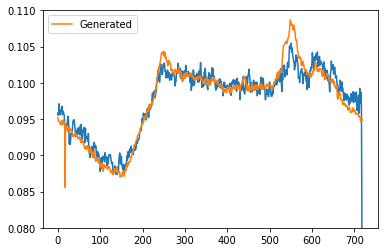

In [234]:
sns.lineplot(range(720), np.average(Q[30 * 720:31 * 720], axis = 1))
sns.lineplot(range(720), np.average(Q_generate[30 * 720:31 * 720], axis = 1), label='Generated')
plt.ylim(0.08, 0.11)

(0.08, 0.11)

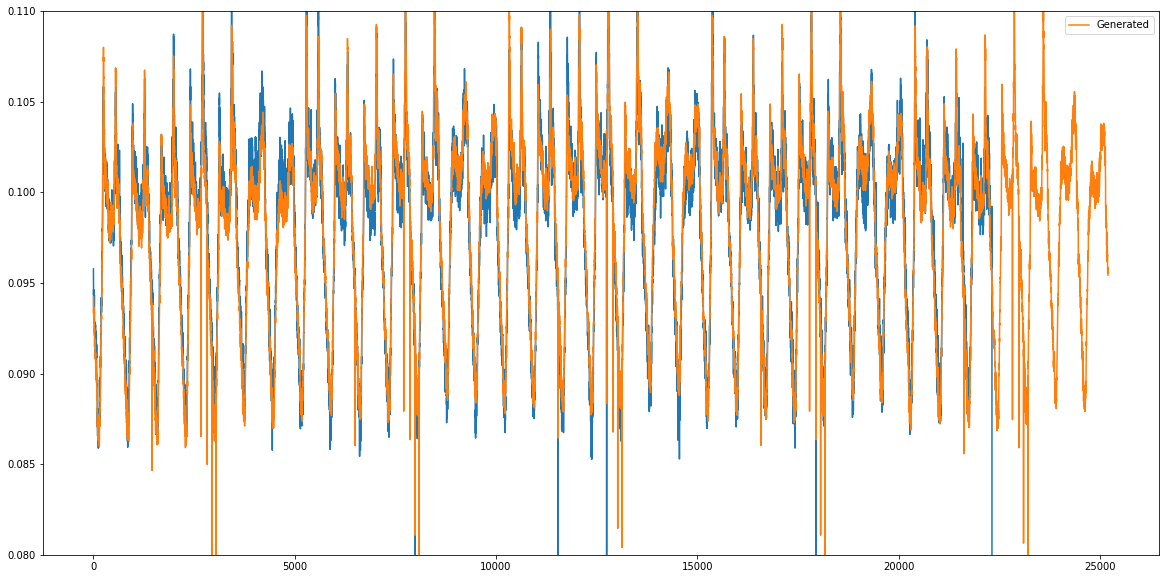

In [237]:
plt.figure(figsize=(20,10))
sns.lineplot(range(len(Q)), np.average(Q, axis = 1))
sns.lineplot(range(len(Q_generate)), np.average(Q_generate, axis = 1), label='Generated')
plt.ylim(0.08, 0.11)

In [245]:
np.save('finalP.npy', P)

In [246]:
np.save('finalQ.npy', Q)

In [247]:
np.save('finalQ_pred.npy', Q_generate)